## IN THIS NOTEBOOK WE HANDLE THE RULES TO MAKE DECISIONS ABOUT CONTRACTS
A rule is defined in our framework as a mapping between an input data x = (x1,x2,...,xM) to the decision y that is contained in the set (accepted, rejected, accepted with extra charge, need for additional information)
Specifically we store all the N rules in a table with N rows and M+1 columns, where the last column contains the decision y. 
The input values x1,...,xM are different in nature and can be for example:
discrete variable, such as the age or BMI, taking discrete values between 1 and 100
binary variables, have you smoked in the last 12 months?: True or False 

In this setting when processing a new input data (x1,x2,...,xM) we need to first match it with the current entries in the table, if a current rule matches the input perfectly, then we return y correponding to that rule. If there is no perfect rule, then we have to match the input value with the closest rule in the current set of rules. 
Given the variablity in the input arguments variables (categorigal, bool, ...) we need to have use a similatity metric that is able to handle them and aggregate them. 

Once the most similar rule (row) is selected, then the y corresponding to that line is returned.

Then we have a set of operational rules, that we will model as another mapping function (x1,...,xM) => y this time we need instead of a table, an analytical function that gives the correct decision for each input. This is the optimal set of rules, that we are trying to learn overtime.

For starting we will work with just M=4 and the variables are BMI, AGE, SMOKER?, PRACTICE_SPORT?
I want you to generate some rules, and the operational rules, and store them into pd dataframes, then I need you to generate the similarity function to retrieve the best rule.


In [1]:
import pandas as pd
import numpy as np

# --------------------------------------------------
# 1. Initial Setup
# --------------------------------------------------
LEARN_FLAG = True  # Global variable controlling self-learning

columns = ['BMI', 'AGE', 'SMOKER', 'PRACTICE_SPORT', 'DECISION', 'COMMENT']

rules_data = [
    [22, 25, False, True,  "accepted", "nothing special, young healthy non-smoker practicing sport"],
    [30, 45, True,  False, "accepted with extra charge", "smoker with moderate BMI, increased premium risk"],
    [27, 35, False, False, "need for additional information", "unclear risk profile, needs more info"],
    [35, 55, True,  False, "rejected", "rejected because of too high risk due to age and smoking"],
    [19, 20, False, True,  "accepted", "nothing special, fit young individual"],
    [25, 40, True,  True,  "accepted with extra charge", "smoker despite doing sports, small surcharge"]
]

rules_df = pd.DataFrame(rules_data, columns=columns)


# --------------------------------------------------
# 2. Operational Analytical Rule
# --------------------------------------------------
def operational_rule(BMI, AGE, SMOKER, PRACTICE_SPORT):
    """
    Analytical rule that determines the ideal decision AND reasoning text.
    """
    if SMOKER and BMI > 30:
        return "rejected", "rejected because of too high risk (obese smoker)"
    elif SMOKER and not PRACTICE_SPORT:
        return "accepted with extra charge", "smoker without physical activity, higher premium"
    elif BMI < 20 and AGE < 25:
        return "accepted", "nothing special, young and healthy"
    elif BMI > 27 and AGE > 50:
        return "rejected", "rejected due to high BMI and age risk"
    elif PRACTICE_SPORT and not SMOKER:
        return "accepted", "nothing special, active non-smoker"
    else:
        return "need for additional information", "unclear case, requires more medical or lifestyle details"


# --------------------------------------------------
# 3. Similarity Function
# --------------------------------------------------
def compute_similarity(row, x_input, w_num=1.0, w_cat=1.0):
    sim = 0
    sim += w_num * (1 - abs(row['BMI'] - x_input['BMI']) / 100)
    sim += w_num * (1 - abs(row['AGE'] - x_input['AGE']) / 100)
    sim += w_cat * (1 if row['SMOKER'] == x_input['SMOKER'] else 0)
    sim += w_cat * (1 if row['PRACTICE_SPORT'] == x_input['PRACTICE_SPORT'] else 0)
    return sim


def find_best_rule(rules_df, x_input):
    similarities = rules_df.apply(lambda r: compute_similarity(r, x_input), axis=1)
    best_idx = similarities.idxmax()
    best_rule = rules_df.loc[best_idx]
    return best_rule, similarities[best_idx]


# --------------------------------------------------
# 4. Decision + Learning Logic (with comments)
# --------------------------------------------------
def decide_and_learn(rules_df, x_input):
    """
    Decide the output for a given input and optionally update the rules table,
    now including a COMMENT explaining the reason for the decision.
    """
    global LEARN_FLAG

    # 1. Compute the ideal decision and comment
    operational_decision, operational_comment = operational_rule(
        x_input['BMI'], x_input['AGE'], x_input['SMOKER'], x_input['PRACTICE_SPORT']
    )

    # 2. Find the closest rule in the current table
    best_rule, similarity = find_best_rule(rules_df, x_input)

    # 3. Check for a perfect match
    perfect_match = (
        (best_rule['BMI'] == x_input['BMI']) and
        (best_rule['AGE'] == x_input['AGE']) and
        (best_rule['SMOKER'] == x_input['SMOKER']) and
        (best_rule['PRACTICE_SPORT'] == x_input['PRACTICE_SPORT'])
    )

    if perfect_match:
        decision = best_rule['DECISION']
        # If decision differs from operational, update
        if decision != operational_decision and LEARN_FLAG:
            rules_df.loc[best_rule.name, ['DECISION', 'COMMENT']] = [operational_decision, operational_comment]
            decision = operational_decision
    else:
        # Use the closest rule's decision (which may be wrong)
        decision = best_rule['DECISION']

        # Learn new rule if enabled
        if LEARN_FLAG:
            new_rule = {
                'BMI': x_input['BMI'],
                'AGE': x_input['AGE'],
                'SMOKER': x_input['SMOKER'],
                'PRACTICE_SPORT': x_input['PRACTICE_SPORT'],
                'DECISION': operational_decision,
                'COMMENT': operational_comment
            }
            rules_df.loc[len(rules_df)] = new_rule

    return decision, operational_decision, rules_df


Simulating: 100%|██████████| 10000/10000 [02:04<00:00, 80.42it/s]


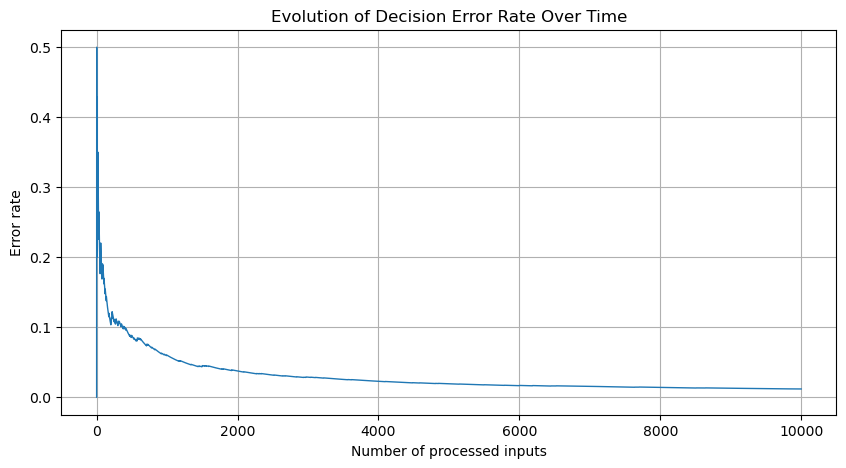

Final error rate after 10000 samples: 0.0118
Total rules learned: 4427


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar

# --------------------------------------------------
# 6. Simulation
# --------------------------------------------------
np.random.seed(42)
n_samples = 10000

# Generate random inputs
inputs = pd.DataFrame({
    'BMI': np.random.randint(15, 40, n_samples),
    'AGE': np.random.randint(18, 70, n_samples),
    'SMOKER': np.random.choice([True, False], n_samples),
    'PRACTICE_SPORT': np.random.choice([True, False], n_samples)
})

error_history = []
false_decisions = 0

# Use tqdm to wrap the iteration
for i, row in tqdm(inputs.iterrows(), total=n_samples, desc="Simulating"):
    x_input = row.to_dict()
    decision, ideal, rules_df = decide_and_learn(rules_df, x_input)
    if decision != ideal:
        false_decisions += 1
    error_rate = false_decisions / (i + 1)
    error_history.append(error_rate)

# --------------------------------------------------
# 7. Plot Error Evolution
# --------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(error_history, linewidth=1)
plt.xlabel("Number of processed inputs")
plt.ylabel("Error rate")
plt.title("Evolution of Decision Error Rate Over Time")
plt.grid(True)
plt.show()

print(f"Final error rate after {n_samples} samples: {error_history[-1]:.4f}")
print(f"Total rules learned: {len(rules_df)}")


In [4]:
error_history

[0.0,
 0.5,
 0.3333333333333333,
 0.25,
 0.2,
 0.3333333333333333,
 0.42857142857142855,
 0.375,
 0.3333333333333333,
 0.3,
 0.2727272727272727,
 0.25,
 0.23076923076923078,
 0.2857142857142857,
 0.26666666666666666,
 0.3125,
 0.29411764705882354,
 0.3333333333333333,
 0.3157894736842105,
 0.35,
 0.3333333333333333,
 0.3181818181818182,
 0.30434782608695654,
 0.2916666666666667,
 0.28,
 0.2692307692307692,
 0.25925925925925924,
 0.25,
 0.2413793103448276,
 0.23333333333333334,
 0.22580645161290322,
 0.25,
 0.24242424242424243,
 0.2647058823529412,
 0.2571428571428571,
 0.25,
 0.24324324324324326,
 0.23684210526315788,
 0.23076923076923078,
 0.225,
 0.21951219512195122,
 0.21428571428571427,
 0.20930232558139536,
 0.20454545454545456,
 0.2,
 0.1956521739130435,
 0.19148936170212766,
 0.1875,
 0.1836734693877551,
 0.18,
 0.17647058823529413,
 0.19230769230769232,
 0.18867924528301888,
 0.18518518518518517,
 0.18181818181818182,
 0.19642857142857142,
 0.21052631578947367,
 0.2068965517241

In [5]:
error_flags

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


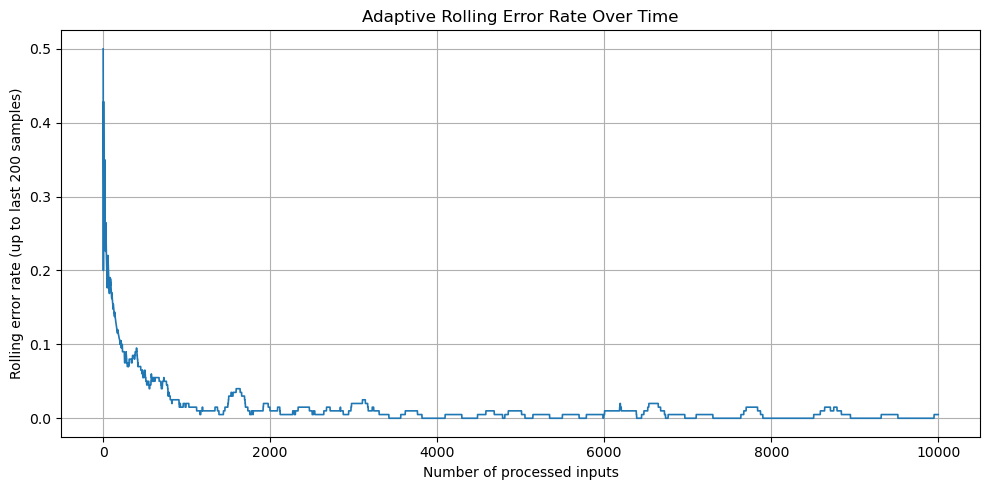

Final rolling error rate (last 200 samples): 0.0050
Total rules learned: 4427


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------------------------------
# 6. Simulation
# --------------------------------------------------
np.random.seed(42)
n_samples = 10000

rules_data = [
    [22, 25, False, True,  "accepted", "nothing special, young healthy non-smoker practicing sport"],
    [30, 45, True,  False, "accepted with extra charge", "smoker with moderate BMI, increased premium risk"],
    [27, 35, False, False, "need for additional information", "unclear risk profile, needs more info"],
    [35, 55, True,  False, "rejected", "rejected because of too high risk due to age and smoking"],
    [19, 20, False, True,  "accepted", "nothing special, fit young individual"],
    [25, 40, True,  True,  "accepted with extra charge", "smoker despite doing sports, small surcharge"]
]

rules_df = pd.DataFrame(rules_data, columns=columns)

# Generate random inputs
inputs = pd.DataFrame({
    'BMI': np.random.randint(15, 40, n_samples),
    'AGE': np.random.randint(18, 70, n_samples),
    'SMOKER': np.random.choice([True, False], n_samples),
    'PRACTICE_SPORT': np.random.choice([True, False], n_samples)
})

error_flags = []

for i, row in tqdm(inputs.iterrows(), total=n_samples, desc="Simulating"):
    x_input = row.to_dict()
    decision, ideal, rules_df = decide_and_learn(rules_df, x_input)
    error_flags.append(1 if decision != ideal else 0)

# --------------------------------------------------
# 7. Rolling Error Rate (adaptive)
# --------------------------------------------------
window_size = 200
# Compute rolling mean, allowing smaller windows at the start
rolling_error = pd.Series(error_flags).rolling(window=window_size, min_periods=1).mean()

# --------------------------------------------------
# 8. Plot Error Evolution
# --------------------------------------------------
plt.figure(figsize=(10, 5))

# Remove the first data point (index 0)
rolling_error_trimmed = rolling_error.iloc[1:]

plt.plot(rolling_error_trimmed.index, rolling_error_trimmed.values, linewidth=1.2)
plt.xlabel("Number of processed inputs")
plt.ylabel(f"Rolling error rate (up to last {window_size} samples)")
plt.title("Adaptive Rolling Error Rate Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final rolling error rate (last {window_size} samples): {rolling_error_trimmed.iloc[-1]:.4f}")
print(f"Total rules learned: {len(rules_df)}")